# Planning a surf trip using IOOS EDS Model Viewer

Created: 2022-11-25

Updated: 2022-11-25

Author: [Mathew Biddle](mailto:mathew.biddle@noaa.gov)

1. Look at significant wave height forecast for MD coast (38.2101 °N 75.0867 °W). Look for significant wave heights >1m or some significant increase to narrow down the investigation. This will get you to a 12-24 hour window typically.
   * Resources in EDS include:
     * Wave Watch III (WW3) WW3 Wave Hgt @ NOAA WW3 Wave Height https://edsdata.oceansmap.com/thredds/catalog/EDS/NOGAPS/catalog.html
     * GFS-Wave WW3 Atlantic Height @ NOAA GFS-Wave Atlantic Wave Height https://eds.ioos.us/thredds/catalog/ioos/gfswave/global/catalog.html
     * The Nearshore Wave Prediction System (NWPS) Chesapeake NWPS AKQ Wave Hgt @ NOAA NWPS Chesapeake Wave Height - https://eds.ioos.us/thredds/catalog/ioos/nwps/akq/catalog.html
     * Best GFS Wave Atlantic Ocean 16km Time Series - https://eds.ioos.us/thredds/dodsC/ioos/gfswave/atlocn/Best, https://eds.ioos.us/thredds/catalog/ioos/gfswave/atlocn/catalog.html?dataset=ioos/gfswave/atlocn/Best
1. Once you find a blip in wave heights, take a look at wave periods in that time period to see if it's just a storm or a decent offshore swell. Typically periods >5 seconds is a good start. That should get you down to a 12 hour window where it might be decent to surf.
1. Next look at the forecasted wave direction and wind direction/speed. Lots of nuances in these two pieces as wind direction could be bad (onshore) but if speeds are low it could be alright. If wind direction good (offshore) but winds are strong, could be tricky. wave direction informs which spots would catch the swell. Not many features on MD coast (barrier island), so direction not as important. This should get you to a 6 hour'ish window.
1. Finally, look at tides and water temp (wetsuit or trunks?), sunrise, sunset times.
1. Run this process every hour leading up to the event - forecast will get more accurate the closer to the event. I will start looking at real-time buoy obs ~12 hours before the event.

In [1]:
# from siphon.catalog import TDSCatalog
# import matplotlib.pyplot as plt
# import numpy as np
# import ipywidgets as widgets

# Set up coordinates for forecast

In [2]:
lat = 38.2101
lon = -75.0867 

lon360 = 360+lon # convert to degrees_east 0-360

print('lat: {}\nlon: {}\nlon360: {}'.format(lat,lon,lon360))

lat: 38.2101
lon: -75.0867
lon360: 284.9133


## Put coordinates on a map

Text(0.5, 1.0, 'lon:-75.0867 lat:38.2101')

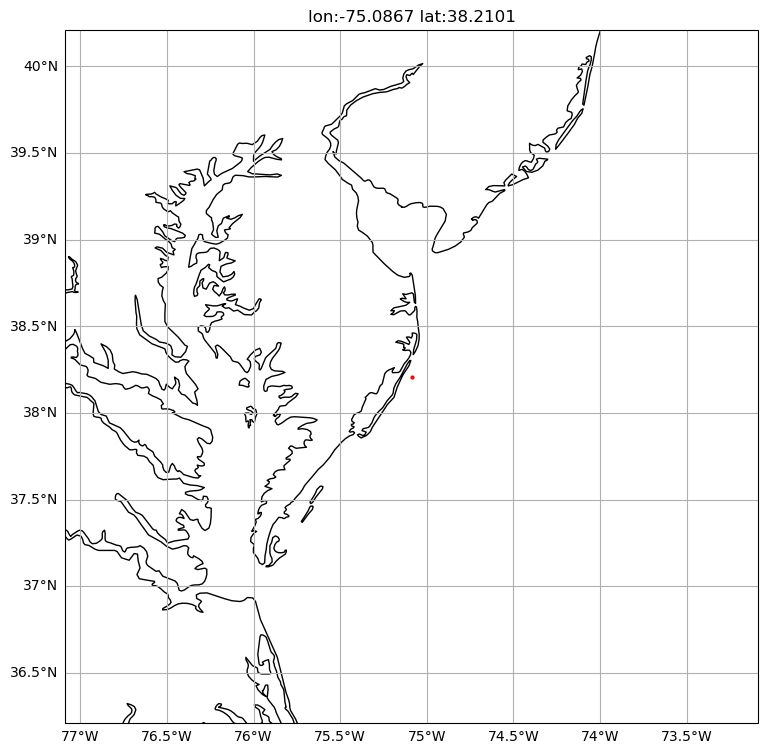

In [3]:
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER
import matplotlib.pyplot as plt

projection=ccrs.PlateCarree() 
figsize=(9, 9)

title='lon:{} lat:{}'.format(lon,lat)

fig, ax = plt.subplots(figsize=figsize, subplot_kw=dict(projection=projection))
gl = ax.gridlines(draw_labels=True)
gl.top_labels = gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

ax.plot(lon, lat, markersize=2, marker='o', color='red')

ax.set_extent([lon-2, lon+2, lat-2, lat+2], ccrs.PlateCarree())

ax.coastlines("10m")

plt.title(title)

# GFS WW3

![image.png](gfs_surf_screenshot.png)

https://eds.ioos.us/thredds/catalog/ioos/gfswave/global/catalog.html

Just use xarray to open dataset directly.

In [4]:
#import cf_xarray
import xarray as xr

In [5]:
url = 'https://eds.ioos.us/thredds/dodsC/ioos/gfswave/global/Best'

ds = xr.open_dataset(url)

wvhgt_gfs = ds.Significant_height_of_combined_wind_waves_and_swell_surface.sel(lat=lat, lon=lon360, method="nearest")

wvhgt_gfs

#wvght = ds['Significant_height_of_combined_wind_waves_and_swell_surface']

<xarray.DataArray 'Significant_height_of_combined_wind_waves_and_swell_surface' (
                                                                                 time: 983)>
[983 values with dtype=float32]
Coordinates:
    lat      float32 38.25
    lon      float32 285.0
  * time     (time) datetime64[ns] 2022-10-29T18:00:00 ... 2022-12-17
    reftime  (time) datetime64[ns] ...
Attributes: (12/13)
    long_name:                       Significant height of combined wind wave...
    units:                           m
    abbreviation:                    HTSGW
    grid_mapping:                    LatLon_Projection
    Grib_Variable_Id:                VAR_7-0--1-3_L1
    Grib2_Parameter:                 [10  0  3]
    ...                              ...
    Grib2_Parameter_Category:        Waves
    Grib2_Parameter_Name:            Significant height of combined wind wave...
    Grib2_Level_Type:                1
    Grib2_Level_Desc:                Ground or water surface
    Grib2_Generating_Process_Type:   Forecast
    Grib2_Statistical_Process_Type:  UnknownStatType--1

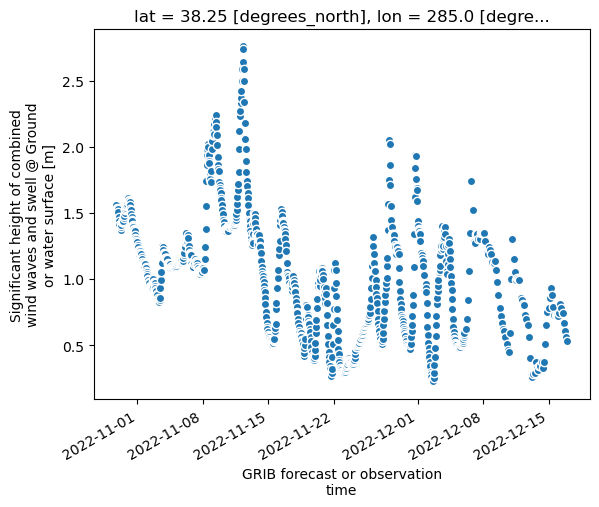

In [6]:
wvhgt_gfs.plot.scatter(x='time')

# NOAA WW3

In [7]:
import datetime

today = datetime.datetime.now().strftime('%Y%m%d')

url = 'http://edsdata.oceansmap.com/thredds/dodsC/EDS/NOGAPS/WW3_WAVE_HGT{}.nc'.format(today)

#url = 'http://edsdata.oceansmap.com/thredds/dodsC/EDS/WW3_ATL_4M/WW3_ATL_4M_best.ncd'

ds = xr.open_dataset(url)

wvhgt_noaa = ds.significant_height_of_combined_wind_waves_and_swells.sel(lat=lat, lon=lon360, method="nearest")

wvhgt_noaa

<xarray.DataArray 'significant_height_of_combined_wind_waves_and_swells' (
                                                                          time: 28)>
[28 values with dtype=float32]
Coordinates:
    lat      float64 38.0
    lon      float64 285.0
  * time     (time) datetime64[ns] 2022-12-01 ... 2022-12-08T12:00:00
Attributes:
    units:                         m
    long_name:                     significant height of combined wind waves ...
    GRIB_param_name:               significant height of combined wind waves ...
    GRIB_center_id:                58
    GRIB_table_id:                 3
    GRIB_param_number:             100
    GRIB_param_id:                 [  1  58   3 100]
    GRIB_product_definition_type:  Forecast/Uninitialized Analysis/Image Product
    GRIB_level_type:               1

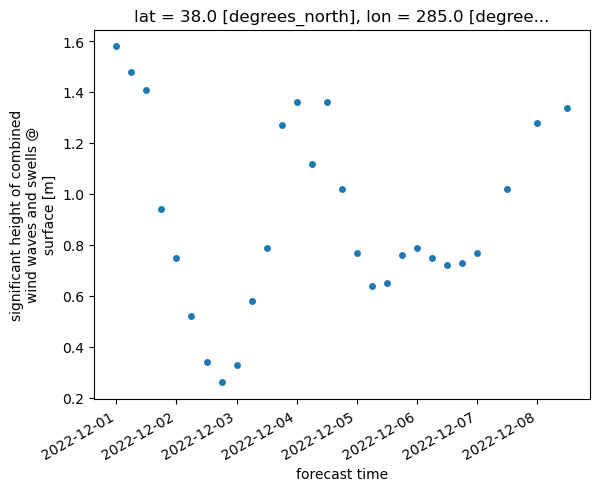

In [8]:
wvhgt_noaa.plot.scatter(x='time')

# Nearshore Wave Prediction System (NWPS) Chesapeake NWPS AKQ Wave Hgt

In [9]:
url = 'https://eds.ioos.us/thredds/dodsC/ioos/nwps/akq/NWPS_AKQ-2022-11-28/LatLon_229X153-37p66N-75p76W'

ds = xr.open_dataset(url)

wvhgt_nwps = ds.Significant_height_of_combined_wind_waves_and_swell_surface.sel(lat=lat, lon=lon360, method="nearest").stack(stacked=("reftime","timeOffset"))

wvhgt_nwps

<xarray.DataArray 'Significant_height_of_combined_wind_waves_and_swell_surface' (
                                                                                 stacked: 435)>
array([2.100586  , 1.9365234 , 1.7675781 , 1.625     , 1.5087891 ,
       1.4121094 , 1.328125  , 1.2626953 , 1.2119141 , 1.1757812 ,
       1.1542969 , 1.1435547 , 1.1386719 , 1.1367188 , 1.1386719 ,
       1.1416016 , 1.1357422 , 1.1132812 , 1.0820312 , 1.0498047 ,
       1.0058594 , 0.95996094, 0.921875  , 0.8886719 , 0.86279297,
       0.84277344, 0.82421875, 0.8100586 , 0.80126953, 0.7973633 ,
       0.78808594, 0.77441406, 0.76220703, 0.7475586 , 0.7285156 ,
       0.70996094, 0.6933594 , 0.67822266, 0.6645508 , 0.64941406,
       0.63134766, 0.6118164 , 0.59277344, 0.5756836 , 0.5605469 ,
       0.5473633 , 0.5366211 , 0.53125   , 0.53466797, 0.55078125,
       0.5800781 , 0.62158203, 0.66308594, 0.69189453, 0.7182617 ,
       0.7451172 , 0.77490234, 0.80029297, 0.83251953, 0.88378906,
       0.953125  , 1.0405273 , 1.15625   , 1.2744141 , 1.3911133 ,
       1.4819336 , 1.5703125 , 1.6640625 , 1.7402344 , 1.8193359 ,
       1.8525391 , 1.8212891 , 1.7558594 , 1.6787109 , 1.546875  ,
       1.4384766 , 1.3740234 , 1.3164062 , 1.2636719 , 1.2119141 ,
       1.1552734 , 1.1025391 , 1.046875  , 0.9902344 , 0.93359375,
       0.8876953 , 0.86328125, 0.8486328 , 0.8339844 , 0.828125  ,
       0.82421875, 0.8173828 , 0.80078125, 0.7861328 , 0.7636719 ,
       0.73535156, 0.70996094, 0.6923828 , 0.6816406 , 0.6777344 ,
...
       1.1899414 , 1.3266602 , 1.4599609 , 1.6044922 , 1.7568359 ,
       1.8574219 , 1.8994141 , 1.8710938 , 1.7900391 , 1.6689453 ,
       1.5537109 , 1.4609375 , 1.3457031 , 1.2529297 , 1.1914062 ,
       1.1445312 , 1.1044922 , 1.0634766 , 1.0205078 , 0.9863281 ,
       0.9472656 , 0.9091797 , 0.87890625, 0.8574219 , 0.84375   ,
       0.8388672 , 0.82910156, 0.81933594, 0.8017578 , 0.7783203 ,
       0.7558594 , 0.73046875, 0.70996094, 0.69628906, 0.68066406,
       0.6621094 , 0.6464844 , 0.6323242 , 0.61572266, 0.609375  ,
       0.6010742 , 0.5908203 , 0.5786133 , 0.56591797, 0.5517578 ,
       0.5361328 , 0.5175781 , 0.48876953, 0.45898438, 0.43066406,
       0.40576172, 0.38330078, 0.3642578 , 0.3540039 , 0.35498047,
       0.3725586 , 0.40478516, 0.44189453, 0.4794922 , 0.5078125 ,
       0.5361328 , 0.5654297 , 0.58984375, 0.6230469 , 0.6582031 ,
       0.68847656, 0.72314453, 0.75683594, 0.7890625 , 0.8232422 ,
       0.84814453, 0.88378906, 0.9199219 , 0.96875   , 1.0292969 ,
       1.0771484 , 1.1328125 , 1.1699219 , 1.1738281 , 1.1601562 ,
       1.1318359 , 1.09375   , 1.0615234 , 1.0273438 , 0.98535156,
       0.95214844, 0.92285156, 0.8935547 , 0.86035156, 0.83203125,
       0.8105469 , 0.7890625 , 0.7734375 , 0.76123047, 0.7548828 ],
      dtype=float32)
Coordinates:
    lat         float32 38.22
    lon         float32 284.9
    time        (stacked) datetime64[ns] 2022-11-28 ... 2022-12-04T12:00:00
  * stacked     (stacked) object MultiIndex
  * reftime     (stacked) datetime64[ns] 2022-11-28 ... 2022-11-28T12:00:00
  * timeOffset  (stacked) float64 0.0 1.0 2.0 3.0 ... 141.0 142.0 143.0 144.0
Attributes: (12/13)
    long_name:                       Significant height of combined wind wave...
    units:                           m
    abbreviation:                    HTSGW
    grid_mapping:                    LatLon_Projection
    Grib_Variable_Id:                VAR_10-0-3_L1
    Grib2_Parameter:                 [10  0  3]
    ...                              ...
    Grib2_Parameter_Category:        Waves
    Grib2_Parameter_Name:            Significant height of combined wind wave...
    Grib2_Level_Type:                1
    Grib2_Level_Desc:                Ground or water surface
    Grib2_Generating_Process_Type:   Forecast
    Grib2_Statistical_Process_Type:  UnknownStatType--1

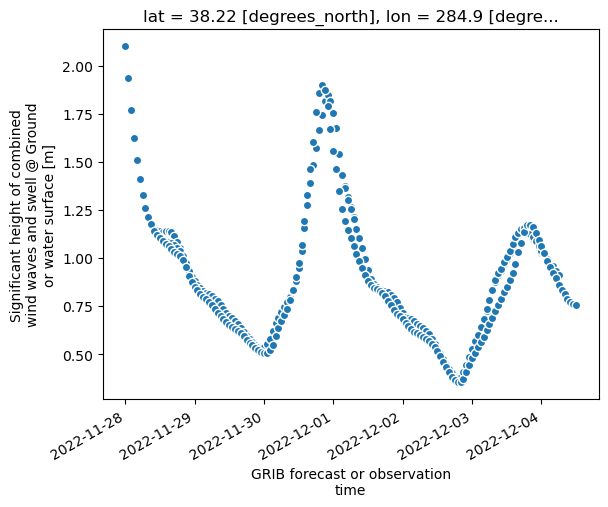

In [10]:
wvhgt_nwps.plot.scatter(x='time')

# Combine them all together in one plot

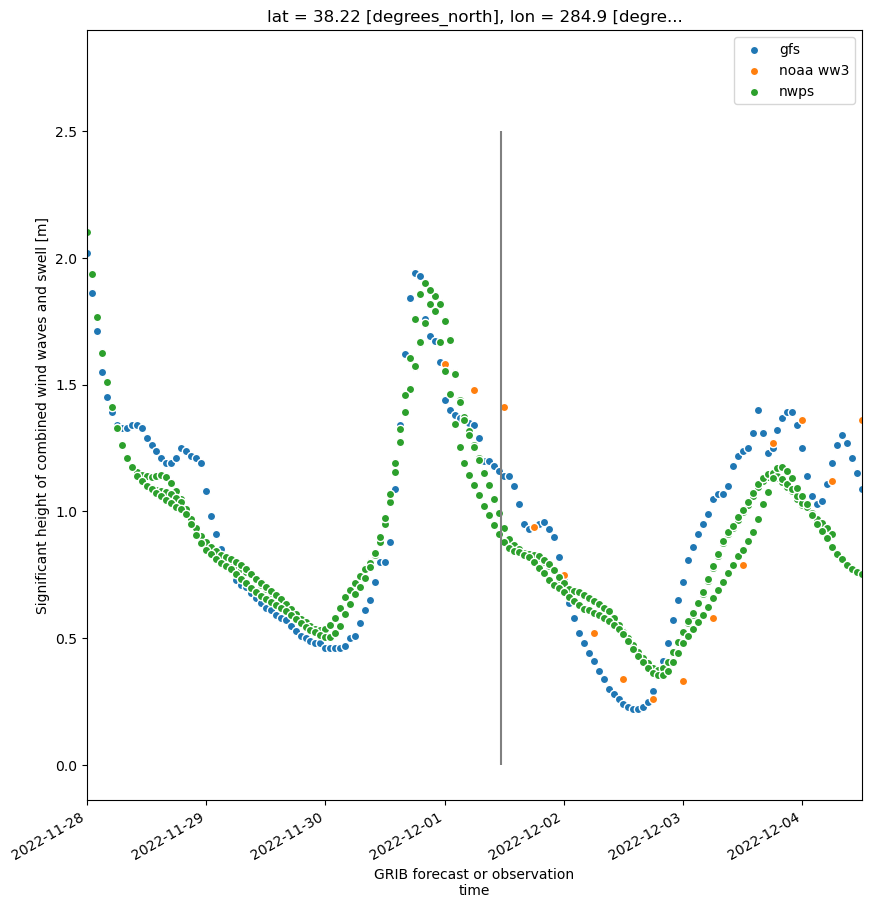

In [11]:
import matplotlib.pyplot as plt

# initialize figure
fig, ax = plt.subplots(figsize=(10, 10))

# add scatter plots
wvhgt_gfs.plot.scatter(x='time',ax=ax, label='gfs')
wvhgt_noaa.plot.scatter(x='time',ax=ax, label='noaa ww3')
wvhgt_nwps.plot.scatter(x='time', ax=ax, label='nwps')

# add legend
ax.legend()

# set limits
ax.set_xlim([wvhgt_nwps.time.min(),wvhgt_nwps.time.max()])

ax.set_ylabel('Significant height of combined wind waves and swell waves [m]')

# add a line for right now
ax.vlines(datetime.datetime.today(),ymin=0,ymax=2.5,color='grey')